# Crime Project - Final Data Analysis

### Changes in Shooting Rates in New York City over Time

Our project will focus on multi-year shooting incidents in New York City. We will compare policing methodologies of the NYPD and how their shooting rate has changed over time. The goal will be to measure the success of applied methodologies by analyzing changes in shootings over a 14-year period. 

In [35]:
#Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gmaps
import fiona
import geopandas
import json
import scipy.stats as sts
from scipy.stats import linregress

# Google developer API key
from api_keys import g_key

# Configure gmaps
gmaps.configure(api_key=g_key)

In [4]:
# Store filepath in a variable and load the data into a dataframe
# History NYC shooting data 2006-2019 & year-to-date data for 2020
# Append the 2 dataframes
shooting_crime_file_historic = "Resources/NYPD_Shooting_Incident_Data__Historic_.csv"
shooting_crime_ytd = "Resources/NYPD_Shooting_Incident_Data__Year_To_Date_.csv"

shooting_df_historic = pd.read_csv(shooting_crime_file_historic)
shooting_df_ytd = pd.read_csv(shooting_crime_ytd)

shooting_df = shooting_df_historic.append(shooting_df_ytd)
shooting_df.head()

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,156430715,09/02/2016,20:36:00,BRONX,44,0.0,NaN,False,NaN,NaN,NaN,25-44,F,BLACK,1007885,246406,40.842979,-73.914580,POINT (-73.91457972899997 40.842979335000045)
1,145001700,08/02/2015,1:30:00,BRONX,43,0.0,NaN,False,NaN,NaN,NaN,<18,F,BLACK,1023203,238742,40.821890,-73.859262,POINT (-73.85926192199997 40.82188959900003)
2,137584243,07/04/2014,22:39:00,MANHATTAN,32,0.0,NaN,False,NaN,NaN,NaN,18-24,M,BLACK,1000493,236572,40.816005,-73.941320,POINT (-73.94131972799995 40.81600451200006)
3,154563857,07/03/2016,1:30:00,BROOKLYN,83,0.0,NaN,False,NaN,NaN,NaN,18-24,M,BLACK,1008115,190458,40.689416,-73.913947,POINT (-73.91394709799994 40.68941602700004)
4,33160009,07/17/2007,23:30:00,BROOKLYN,71,0.0,NaN,False,NaN,NaN,NaN,<18,M,BLACK,995163,178527,40.656694,-73.960670,POINT (-73.96066977199997 40.656693553000025)


In [5]:
# NYC population data
boroughs = ["BRONX","BROOKLYN","MANHATTAN","QUEENS","STATEN ISLAND"]
counties = ["Bronx","Kings","New York","Queens","Richmond"]
population_estimate = [1418207,2559903,1628706,2253858,476143]
gdp_billions = [42695,91559,600244,93310,14514]
gdp_per_capita = [30100,35800,368500,41400,30500]
land_area_miles = [42.10,70.82,22.83,108.53,58.37]
land_area_km = [109.04,183.42,59.13,281.09,151.18]
density_persons_sm = [33867,36147,71341,20767,8157]
density_persons_km = [13006,13957,27544,8018,3150]

nyc_five_boroughs_df = pd.DataFrame({
    "BORO" : boroughs,
    "Counties" : counties,
    "Population" : population_estimate,
    "GDP Billions" : gdp_billions,
    "GDP Per Capita" : gdp_per_capita,
    "Land Area Miles" : land_area_miles,
    "Land Area Kilometers" : land_area_km,
    "Density Persons Square Miles" : density_persons_sm,
    "Density Persons Kilometers" : density_persons_km
})

nyc_five_boroughs_df.head()

,BORO,Counties,Population,GDP Billions,GDP Per Capita,Land Area Miles,Land Area Kilometers,Density Persons Square Miles,Density Persons Kilometers
0,BRONX,Bronx,1418207,42695,30100,42.10,109.04,33867,13006
1,BROOKLYN,Kings,2559903,91559,35800,70.82,183.42,36147,13957
2,MANHATTAN,New York,1628706,600244,368500,22.83,59.13,71341,27544
3,QUEENS,Queens,2253858,93310,41400,108.53,281.09,20767,8018
4,STATEN ISLAND,Richmond,476143,14514,30500,58.37,151.18,8157,3150


In [6]:
#Adding columns for the year and month
shooting_df["Year"] = pd.DatetimeIndex(shooting_df['OCCUR_DATE']).year
shooting_df["ShootingMonth"] = pd.DatetimeIndex(shooting_df['OCCUR_DATE']).month
shooting_df.head()

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,PRECINCT,JURISDICTION_CODE,LOCATION_DESC,STATISTICAL_MURDER_FLAG,PERP_AGE_GROUP,PERP_SEX,...,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat,Year,ShootingMonth
0,156430715,09/02/2016,20:36:00,BRONX,44,0.0,NaN,False,NaN,NaN,...,25-44,F,BLACK,1007885,246406,40.842979,-73.914580,POINT (-73.91457972899997 40.842979335000045),2016,9
1,145001700,08/02/2015,1:30:00,BRONX,43,0.0,NaN,False,NaN,NaN,...,<18,F,BLACK,1023203,238742,40.821890,-73.859262,POINT (-73.85926192199997 40.82188959900003),2015,8
2,137584243,07/04/2014,22:39:00,MANHATTAN,32,0.0,NaN,False,NaN,NaN,...,18-24,M,BLACK,1000493,236572,40.816005,-73.941320,POINT (-73.94131972799995 40.81600451200006),2014,7
3,154563857,07/03/2016,1:30:00,BROOKLYN,83,0.0,NaN,False,NaN,NaN,...,18-24,M,BLACK,1008115,190458,40.689416,-73.913947,POINT (-73.91394709799994 40.68941602700004),2016,7
4,33160009,07/17/2007,23:30:00,BROOKLYN,71,0.0,NaN,False,NaN,NaN,...,<18,M,BLACK,995163,178527,40.656694,-73.960670,POINT (-73.96066977199997 40.656693553000025),2007,7


## Demograpics of Victims

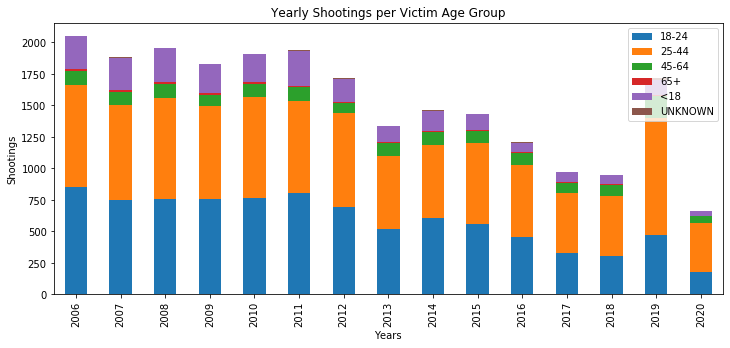

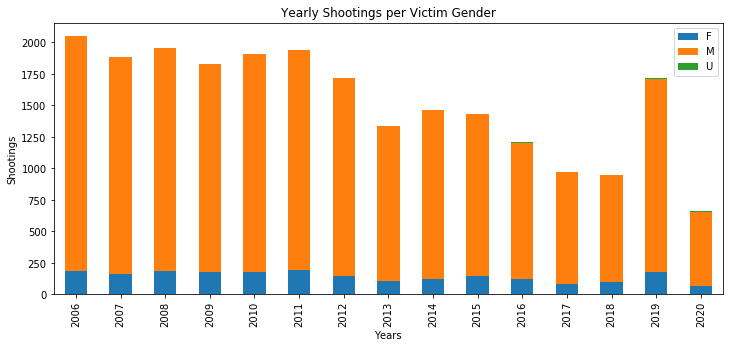

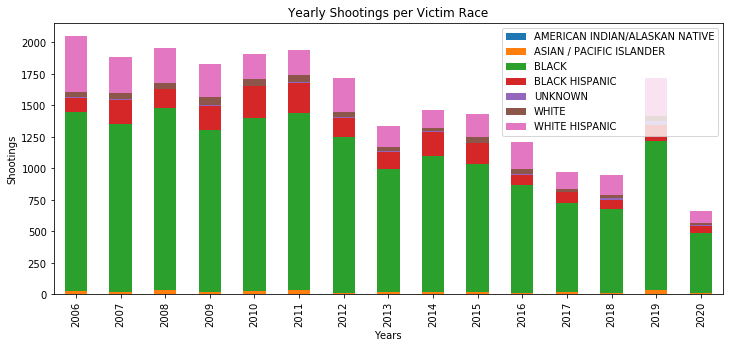

In [17]:
# Evaluating victom demographcs looking at age group, gender, and race
# Age Group
shooting_victim_age_counts = shooting_df.groupby(["Year","VIC_AGE_GROUP"])["Year"].count().unstack("VIC_AGE_GROUP")

shooting_victim_age_counts.plot(kind="bar",stacked=True,figsize=(12,5))
plt.legend(loc="upper right")

plt.title("Yearly Shootings per Victim Age Group")
plt.xlabel("Years")
plt.ylabel("Shootings")

# Save Age Group Image
plt.savefig("Images/NYC_Shootings_Demographics_AgeGroup.png")

# Gender
shooting_victim_sex_counts = shooting_df.groupby(["Year","VIC_SEX"])["Year"].count().unstack("VIC_SEX")

shooting_victim_sex_counts.plot(kind="bar",stacked=True,figsize=(12,5))
plt.legend(loc="best")

plt.title("Yearly Shootings per Victim Gender")
plt.xlabel("Years")
plt.ylabel("Shootings")

# Save Gender Image
plt.savefig("Images/NYC_Shootings_Demographics_Gender.png")

# Race
shooting_victim_race_counts = shooting_df.groupby(["Year","VIC_RACE"])["Year"].count().unstack("VIC_RACE")

shooting_victim_race_counts.plot(kind="bar",stacked=True,figsize=(12,5))
plt.legend(loc="best")

plt.title("Yearly Shootings per Victim Race")
plt.xlabel("Years")
plt.ylabel("Shootings")

# Save Race Image
plt.savefig("Images/NYC_Shootings_Demographics_Race.png")

plt.show()

### Question: What are the demographics of victims? Are there patterns/trends based on victim demographics?

In the age buckets, the predominate ages of shooting victims are the 18-24 and 25-44 age ranges. The 25-44 age range is the largest range of ages of shooting victims. There was a spike in this age range in 2019. 

The predominant gender of shooting victims are male. 

As far as race, a majority of the shooting victims are Black. The second closest race is White Hispanic.

## Shootings by Borough

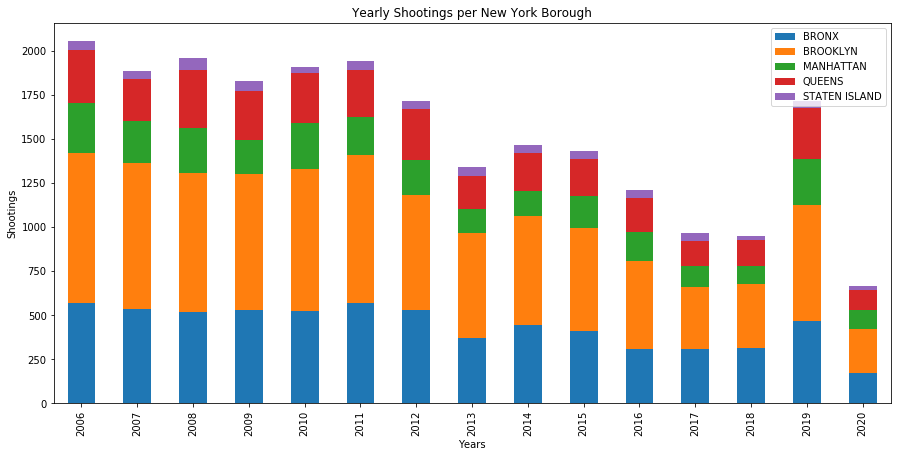

In [19]:
#Shootings grouped by year and borough
shooting_counts = shooting_df.groupby(["Year","BORO"])["Year"].count().unstack("BORO")

shooting_counts.plot(kind="bar",stacked=True,figsize=(15,7))
plt.legend(loc="best")
plt.title("Yearly Shootings per New York Borough")
plt.xlabel("Years")
plt.ylabel("Shootings")

# Save Shootings by Borough Image
plt.savefig("Images/NYC_Shootings_Borough.png")

plt.show()

In [24]:
# Store latitude and longitude in locations
locations = shooting_df[["Latitude", "Longitude"]]

# Fill NaN values and convert to float
#weights = shooting_df["Year"].astype(float)

# Plot Heatmap
fig = gmaps.figure(center=(40.7128,-74.0060),zoom_level=10)

# Create heat layer
heat_layer = gmaps.heatmap_layer(locations)

# Add layer
fig.add_layer(heat_layer)

gmaps.configure(api_key=g_key)
with open('Resources/Borough Boundaries.geojson') as f:
    geometry = json.load(f)
geojson_layer = gmaps.geojson_layer(geometry, fill_color="white", fill_opacity=0.0, stroke_weight=2)
fig.add_layer(geojson_layer)

# Save heatmap image
####### DIDN'T GET TO WORK #########

# Display figure
fig

Figure(layout=FigureLayout(height='420px'))

### Question: Where are shootings more prevalent in New York (analyzed by borough)?

The Brooklyn borough has the most shootings than any of the other boroughs. 

## Shootings Over Time: Impact of Policing Strategies

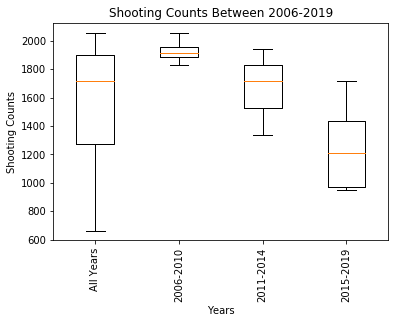

In [38]:
# Shootings Over Time - Bucketing by the years of different strategies

# All Years
shooting_year_groupby = shooting_df.groupby(["Year"])
shooting_year_counts = shooting_year_groupby["INCIDENT_KEY"].count()

# 2006-2010
shootings_2006_2010_df = shooting_df.loc[(shooting_df["Year"] >= 2006) &
                                        (shooting_df["Year"] < 2011)]
shooting_2006_2010_groupby = shootings_2006_2010_df.groupby(["Year"])
shooting_2006_2010_counts = shooting_2006_2010_groupby["INCIDENT_KEY"].count()

# 2011-2014 (4 years prior to neighborhood policing strategy)
shootings_2011_2014_df = shooting_df.loc[(shooting_df["Year"] >= 2011) &
                                        (shooting_df["Year"] < 2014)]
shooting_2011_2014_groupby = shootings_2011_2014_df.groupby(["Year"])
shooting_2011_2014_counts = shooting_2011_2014_groupby["INCIDENT_KEY"].count()

# 2015-2019 (4 years after the neighborhood policing strategy was implemented)
shootings_2015_df = shooting_df.loc[(shooting_df["Year"] >= 2015) &
                                        (shooting_df["Year"] < 2020)]
shooting_2015_groupby = shootings_2015_df.groupby(["Year"])
shooting_2015_counts = shooting_2015_groupby["INCIDENT_KEY"].count()

# Combine data to create box plot of the time frames
shooting_year_counts_df = pd.DataFrame(shooting_year_counts)
shooting_2006_2010_counts_df = pd.DataFrame(shooting_2006_2010_counts)
shooting_2011_2014_counts_df = pd.DataFrame(shooting_2011_2014_counts)
shooting_2015_counts_df = pd.DataFrame(shooting_2015_counts)

combine = [shooting_year_counts_df["INCIDENT_KEY"],
           shooting_2006_2010_counts_df["INCIDENT_KEY"],
           shooting_2011_2014_counts_df["INCIDENT_KEY"],
           shooting_2015_counts_df["INCIDENT_KEY"]]

year_groupings = ["All Years", "2006-2010", "2011-2014", "2015-2019"]
tick_locations = [1,2,3,4]

fig5,ax5 = plt.subplots()
ax5.set_ylabel("Shooting Counts")
ax5.set_xlabel("Years")
ax5.set_title("Shooting Counts Between 2006-2019")
outlier = dict(marker="o", markerfacecolor="red", markersize=10)
ax5.boxplot(combine,flierprops=outlier)
plt.xticks(tick_locations,year_groupings)
plt.xticks(rotation=90)

# Save statistical analysis box plot
plt.savefig("Images/NYC_Shootings_YearsAnalysis.png")

plt.show()

In [37]:
# Statistical Analysis in the year buckets
# Average of each year range
mean_shootings = np.mean(shooting_year_counts)
mean_shootings_2006_2010 = np.mean(shooting_2006_2010_counts)
mean_shootings_2011_2014 = np.mean(shooting_2011_2014_counts)
mean_shootings_2015_2019 = np.mean(shooting_2015_counts)

# Median
median_shootings = np.median(shooting_year_counts)
median_shootings_2006_2010 = np.median(shooting_2006_2010_counts)
median_shootings_2011_2014 = np.median(shooting_2011_2014_counts)
median_shootings_2015 = np.median(shooting_2015_counts)

# Mode
mode_shootings = sts.mode(shooting_year_counts)
mode_shootings_2006_2010 = sts.mode(shooting_2006_2010_counts)
mode_shootings_2011_2014 = sts.mode(shooting_2011_2014_counts)
mode_shootings_2015 = sts.mode(shooting_2015_counts)

perc_change = (mean_shootings_2011_2014 - mean_shootings_2015_2019) / mean_shootings_2011_2014

print(f"The mean shootings of all years 2006-2020 is {mean_shootings}")
print(f"The mean shootings of years 2006-2010 is {mean_shootings_2006_2010}")
print(f"The mean shootings of years 2011-2014 is {mean_shootings_2011_2014}")
print(f"The mean shootings of years 2015-2019 is {mean_shootings_2015_2019}")
print(f"")
print(f"The median shootings of all years 2006-2020 is {median_shootings}")
print(f"The median shootings of years 2006-2010 is {median_shootings_2006_2010}")
print(f"The median shootings of years 2011-2014 is {median_shootings_2011_2014}")
print(f"The median shootings of years 2015-2019 is {median_shootings_2015}")
print(f"")
print(f"The mode shootings of all years 2006-2020 is {mode_shootings}")
print(f"The mode shootings of years 2006-2010 is {mode_shootings_2006_2010}")
print(f"The mode shootings of years 2011-2014 is {mode_shootings_2011_2014}")
print(f"The mode shootings of years 2015-2019 is {mode_shootings_2015}")
print(f"")
print(f"The percent change of the average between 2011-2014 and 2015-2019 is {perc_change}")

The mean shootings of all years 2006-2020 is 1535.9333333333334
The mean shootings of years 2006-2010 is 1927.6
The mean shootings of years 2011-2014 is 1665.0
The mean shootings of years 2015-2019 is 1255.6

The median shootings of all years 2006-2020 is 1716.0
The median shootings of years 2006-2010 is 1910.0
The median shootings of years 2011-2014 is 1717.0
The median shootings of years 2015-2019 is 1208.0

The mode shootings of all years 2006-2020 is ModeResult(mode=array([664], dtype=int64), count=array([1]))
The mode shootings of years 2006-2010 is ModeResult(mode=array([1828], dtype=int64), count=array([1]))
The mode shootings of years 2011-2014 is ModeResult(mode=array([1339], dtype=int64), count=array([1]))
The mode shootings of years 2015-2019 is ModeResult(mode=array([951], dtype=int64), count=array([1]))

The percent change of the average between 2011-2014 and 2015-2019 is 0.24588588588588595


### Question: How were shooting incidents statistically impacted by implemented strategies?

In 2015, the Neighborhood Policing strategy was introduced. Between the years of 2015-2019 the number of shootings were reduced. The average shootings dropped by 24.6%. 